<a href="https://colab.research.google.com/github/pasdptt/PasdPublicNB/blob/master/Modeling_Unsupervised.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install Spark + import lib + start spark session


In [ ]:
!apt-get update

Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [697 B]
Hit:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release.gpg [836 B]
Get:7 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Get:8 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:10 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:11 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:12 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Ign:13 https://developer.download.nvidia.com/

In [ ]:
#Get Install the Java Development Kit
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
#Get Spark lib -- address need to be change according to the current version of Spark: https://downloads.apache.org/spark/
!wget -q http://apache.osuosl.org/spark/spark-3.0.3/spark-3.0.3-bin-hadoop3.2.tgz
#Unzip th Spark
!tar xf spark-3.0.3-bin-hadoop3.2.tgz
#install findspark for Python
!pip install -q findspark
#Install extra lib(s)
!pip install -q xlrd
!pip install -q kaggle
!pip install -q kora

#import and set environment for spark
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.3-bin-hadoop3.2"

import kora
import pandas as pd

import findspark
findspark.init()
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql import *

SPARK_URL = "local[*]"

spark = SparkSession.builder.master(SPARK_URL).getOrCreate()

# Check the pyspark version
import pyspark
print(pyspark.__version__)

     |████████████████████████████████| 51kB 1.5MB/s 
3.0.1


In [ ]:
from __future__ import print_function

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.datasets.samples_generator import make_blobs
from pyspark import SparkContext
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler
from pyspark.sql import SQLContext

%matplotlib inline

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.datasets.samples_generator module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.datasets. Anything that cannot be imported from sklearn.datasets is now part of the private API.
  warnings.warn(message, FutureWarning)


#Getting Mock Dataset

We also want to have some data to work with. A simple way to get that is to generate it using scikit-learn's method to generate ten blobs in a three-dimensional space.

To make it more realistic we also add an 'id' column of strings, which in real life is often the customer id or the IP address of the IoT device, or similar.

Last we write the dataset as a CSV file, which despite being an awful format, is the one I encounter every day.

In [ ]:
n_samples=10000
n_features=3
X, y = make_blobs(n_samples=n_samples, centers=10, n_features=n_features, random_state=42)

# add a row index as a string
pddf = pd.DataFrame(X, columns=['x', 'y', 'z'])
pddf['id'] = 'row'+pddf.index.astype(str)

#move it first (left)
cols = list(pddf)
cols.insert(0, cols.pop(cols.index('id')))
pddf = pddf.loc[:, cols]
pddf.head()

# save the ndarray as a csv file
pddf.to_csv('input.csv', index=False)

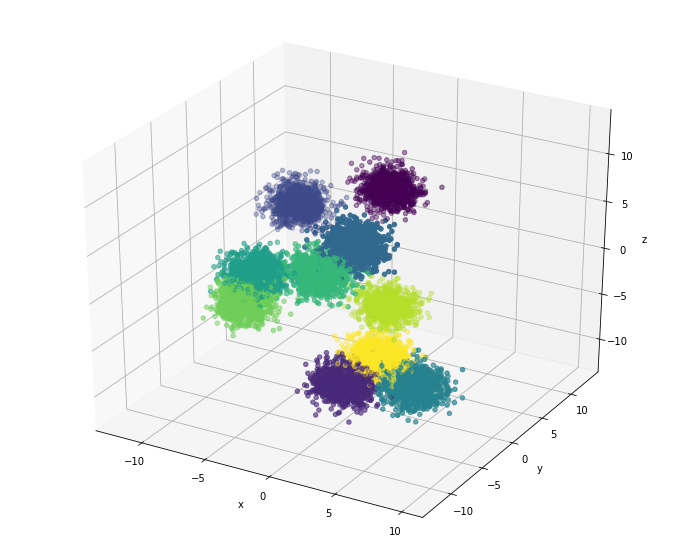

In [ ]:
threedee = plt.figure(figsize=(12,10)).gca(projection='3d')
threedee.scatter(X[:,0], X[:,1], X[:,2], c=y)
threedee.set_xlabel('x')
threedee.set_ylabel('y')
threedee.set_zlabel('z')
plt.show()

#Exploring Data

In [ ]:
FEATURES_COL = ['x', 'y', 'z']
path = 'input.csv'

In [ ]:
df = spark.read.options(header="true",inferschema = "true").csv(path)
df.show()

+-----+--------------------+-------------------+-------------------+
|   id|                   x|                  y|                  z|
+-----+--------------------+-------------------+-------------------+
| row0|  -6.077699676970267|-2.9096103057273632|-1.5181728865169748|
| row1| -1.0122600489217026|  7.322841304183577| -5.442407430432608|
| row2|  -8.297006462627731| 6.3228935430154625|  1.167204760454971|
| row3|  -3.507121456057238|  4.784811751712145|  -5.44494747291675|
| row4|   -5.12282340491732| -3.322049741451506|-0.5069804719890176|
| row5|  -2.476400627641164|  8.255790793498251| 4.4094781220223345|
| row6|   7.315395347991067| -5.079448952098217| -7.291214948142356|
| row7|  -2.016746359044601|   9.30345477210614|  7.095178976138996|
| row8|-0.23381850372561575| -4.892681101883508| 2.1228876266871093|
| row9|   6.565442081261875| -6.855994160254796| -6.798321268724102|
|row10|  -5.690284570490115| -6.482740258743004|-0.9246966808128123|
|row11|-0.01798614270656...|  2.76

##Check Schema and DataType

In [ ]:
df.printSchema()

root
 |-- id: string (nullable = true)
 |-- x: double (nullable = true)
 |-- y: double (nullable = true)
 |-- z: double (nullable = true)



##Check "Null"

In [ ]:
from pyspark.sql.functions import isnan, when, count, col

df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+---+---+---+---+
| id|  x|  y|  z|
+---+---+---+---+
|  0|  0|  0|  0|
+---+---+---+---+



In [ ]:
df.describe().show()

+-------+-------+-------------------+-------------------+-------------------+
|summary|     id|                  x|                  y|                  z|
+-------+-------+-------------------+-------------------+-------------------+
|  count|  10000|              10000|              10000|              10000|
|   mean|   null|-1.4042826560813755|-1.0639771040701707|-1.2173489481291988|
| stddev|   null|  4.825849327260164|  6.276823840204043|  5.728730293325607|
|    min|   row0| -12.07984158196513|-12.555063182824682|-11.886802240077339|
|    max|row9999|  9.934576529690277| 12.940523834634648| 12.775965284529248|
+-------+-------+-------------------+-------------------+-------------------+



In [ ]:
##In case you need to remove null
df = df.na.drop()
df.show()

+-----+--------------------+-------------------+-------------------+
|   id|                   x|                  y|                  z|
+-----+--------------------+-------------------+-------------------+
| row0|  -6.077699676970267|-2.9096103057273632|-1.5181728865169748|
| row1| -1.0122600489217026|  7.322841304183577| -5.442407430432608|
| row2|  -8.297006462627731| 6.3228935430154625|  1.167204760454971|
| row3|  -3.507121456057238|  4.784811751712145|  -5.44494747291675|
| row4|   -5.12282340491732| -3.322049741451506|-0.5069804719890176|
| row5|  -2.476400627641164|  8.255790793498251| 4.4094781220223345|
| row6|   7.315395347991067| -5.079448952098217| -7.291214948142356|
| row7|  -2.016746359044601|   9.30345477210614|  7.095178976138996|
| row8|-0.23381850372561575| -4.892681101883508| 2.1228876266871093|
| row9|   6.565442081261875| -6.855994160254796| -6.798321268724102|
|row10|  -5.690284570490115| -6.482740258743004|-0.9246966808128123|
|row11|-0.01798614270656...|  2.76

#Prep data for model
Doing some vertorizing

In [ ]:
vecAssembler = VectorAssembler(inputCols=FEATURES_COL, outputCol="features")
df_kmeans = vecAssembler.transform(df).select('id', 'features')
df_kmeans.show()

+-----+--------------------+
|   id|            features|
+-----+--------------------+
| row0|[-6.0776996769702...|
| row1|[-1.0122600489217...|
| row2|[-8.2970064626277...|
| row3|[-3.5071214560572...|
| row4|[-5.1228234049173...|
| row5|[-2.4764006276411...|
| row6|[7.31539534799106...|
| row7|[-2.0167463590446...|
| row8|[-0.2338185037256...|
| row9|[6.56544208126187...|
|row10|[-5.6902845704901...|
|row11|[-0.0179861427065...|
|row12|[-6.9042625162071...|
|row13|[-10.389865177604...|
|row14|[3.96886833004396...|
|row15|[-7.3370519870306...|
|row16|[-8.9915883100353...|
|row17|[-0.1809858409434...|
|row18|[3.31939544014348...|
|row19|[-2.0266334941663...|
+-----+--------------------+
only showing top 20 rows



##Optimize choice of k
One disadvantage of KMeans compared to more advanced clustering algorithms is that the algorithm must be told how many clusters, k, it should try to find. 

###Elbow Method
To optimize k we cluster a fraction of the data for different choices of k and look for an "elbow" in the cost function.

(However, may not good due to require to convert to PD)

In [ ]:
cost = np.zeros(20)
for k in range(2,20):
    kmeans = KMeans().setK(k).setSeed(1).setFeaturesCol("features")
    model = kmeans.fit(df_kmeans.sample(False,0.1, seed=42))
    cost[k] = model.summary.trainingCost # requires Spark 2.0 or later

Text(0, 0.5, 'cost')

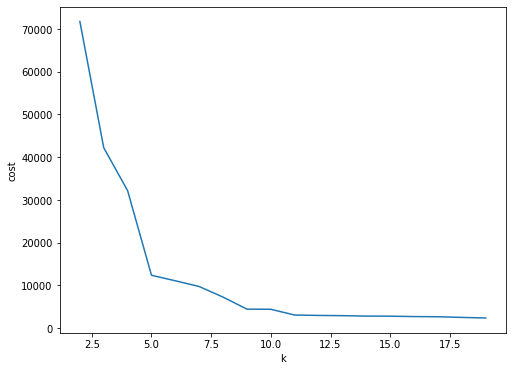

In [ ]:
fig, ax = plt.subplots(1,1, figsize =(8,6))
ax.plot(range(2,20),cost[2:20])
ax.set_xlabel('k')
ax.set_ylabel('cost')

###Silhouette
The silhouette value is a measure of how similar an object is to its own cluster (cohesion) compared to other clusters (separation). The silhouette ranges from −1 to +1, where a high value indicates that the object is well matched to its own cluster and poorly matched to neighboring clusters. If most objects have a high value, then the clustering configuration is appropriate. If many points have a low or negative value, then the clustering configuration may have too many or too few clusters.

The silhouette can be calculated with any distance metric, such as the Euclidean distance or the Manhattan distance.

In [ ]:
from pyspark.ml.evaluation import *

cost = list()
evaluator = ClusteringEvaluator()
for k in range(2,20):
    bkm = KMeans().setK(k).setSeed(1).setFeaturesCol("features")
    bkm_model = bkm.fit(df_kmeans.sample(False,0.1, seed=42))
    tags_predictions = bkm_model.transform(df_kmeans.sample(False,0.1, seed=42))
    silhouette = evaluator.evaluate(tags_predictions)
    cost.append(silhouette)
    
kIdx = np.argmax(cost)


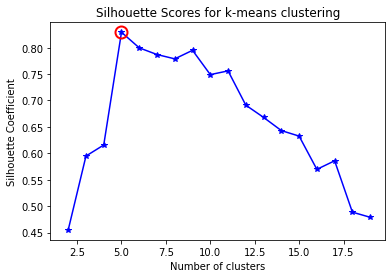

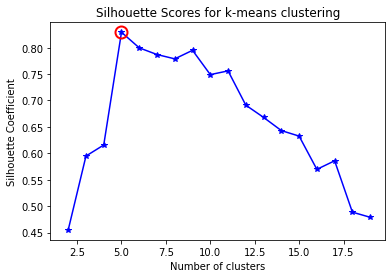

In [ ]:
fig, ax = plt.subplots()
plt.plot(range(2,20), cost, 'b*-')
plt.plot(range(2,20)[kIdx], cost[kIdx], marker='o', markersize=12, 
         markeredgewidth=2, markeredgecolor='r', markerfacecolor='None')
plt.xlim(1, plt.xlim()[1])
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Coefficient')
plt.title('Silhouette Scores for k-means clustering')
# Uncomment the next line
display(fig)

### Choose K

In [ ]:
k = 5
kmeans = KMeans().setK(k).setSeed(1).setFeaturesCol("features")
model = kmeans.fit(df_kmeans)
centers = model.clusterCenters()

print("Cluster Centers: ")
for center in centers:
    print(center)

Cluster Centers: 
[ 4.29728146 -6.32339573 -6.60136378]
[ 4.11111715 -9.61155032  9.41405178]
[-4.9545928  -4.09830766  0.02879097]
[-0.31260155  3.77092519 -7.55332037]
[-5.62976257  8.18582167  3.31772707]


#Train Model

In [ ]:
transformed = model.transform(df_kmeans).select('id', 'prediction')
rows = transformed.collect()
print(rows[:3])

[Row(id='row0', prediction=2), Row(id='row1', prediction=3), Row(id='row2', prediction=4)]


In [ ]:
df_pred = spark.createDataFrame(rows)
df_pred.show()

+-----+----------+
|   id|prediction|
+-----+----------+
| row0|         2|
| row1|         3|
| row2|         4|
| row3|         3|
| row4|         2|
| row5|         4|
| row6|         0|
| row7|         4|
| row8|         2|
| row9|         0|
|row10|         2|
|row11|         3|
|row12|         2|
|row13|         4|
|row14|         0|
|row15|         2|
|row16|         4|
|row17|         3|
|row18|         0|
|row19|         2|
+-----+----------+
only showing top 20 rows



In [ ]:
df_pred = df_pred.join(df, 'id')
df_pred.show()

+-----+----------+--------------------+-------------------+-------------------+
|   id|prediction|                   x|                  y|                  z|
+-----+----------+--------------------+-------------------+-------------------+
| row0|         2|  -6.077699676970267|-2.9096103057273632|-1.5181728865169748|
| row1|         3| -1.0122600489217026|  7.322841304183577| -5.442407430432608|
| row2|         4|  -8.297006462627731| 6.3228935430154625|  1.167204760454971|
| row3|         3|  -3.507121456057238|  4.784811751712145|  -5.44494747291675|
| row4|         2|   -5.12282340491732| -3.322049741451506|-0.5069804719890176|
| row5|         4|  -2.476400627641164|  8.255790793498251| 4.4094781220223345|
| row6|         0|   7.315395347991067| -5.079448952098217| -7.291214948142356|
| row7|         4|  -2.016746359044601|   9.30345477210614|  7.095178976138996|
| row8|         2|-0.23381850372561575| -4.892681101883508| 2.1228876266871093|
| row9|         0|   6.565442081261875| 

#Verify Model

In [ ]:
pddf_pred = df_pred.toPandas().set_index('id')
pddf_pred.head()

,prediction,x,y,z
id,,,,
row0,2,-6.077700,-2.909610,-1.518173
row1,3,-1.012260,7.322841,-5.442407
row2,4,-8.297006,6.322894,1.167205
row3,3,-3.507121,4.784812,-5.444947
row4,2,-5.122823,-3.322050,-0.506980


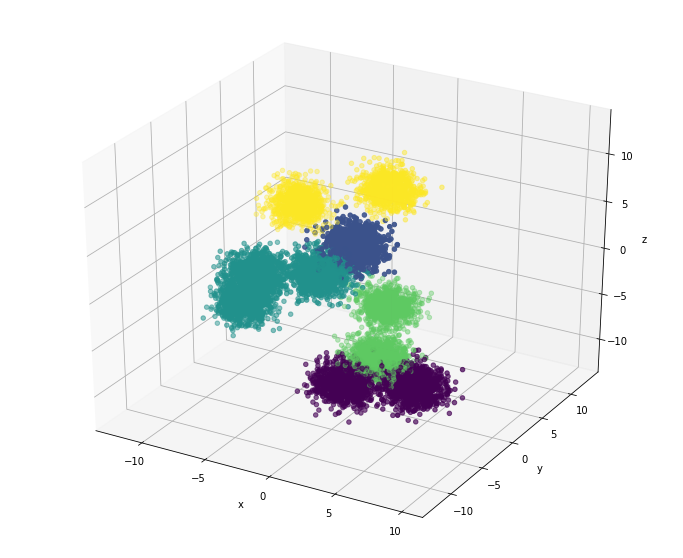

In [ ]:
threedee = plt.figure(figsize=(12,10)).gca(projection='3d')
threedee.scatter(pddf_pred.x, pddf_pred.y, pddf_pred.z, c=pddf_pred.prediction)
threedee.set_xlabel('x')
threedee.set_ylabel('y')
threedee.set_zlabel('z')
plt.show()

In [ ]:
model.save("./KMeansModel")

### Load Model ###
#sameModel = KMeansModel.load(sc, ###)